In [125]:
import pandas as pd
from datetime import timedelta
from scipy.stats import shapiro, mannwhitneyu, kruskal
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt

In [68]:
data = pd.read_csv(r'D:\Projects_py\stepik_adv_py\lab5\churn.csv')

In [69]:
# Перетворюємо стовпці з датами у тип datetime
data['last_trip_date'] = pd.to_datetime(data['last_trip_date'])
data['signup_date'] = pd.to_datetime(data['signup_date'])

In [70]:
# Визначаємо максимальну дату останньої поїздки
max_last_trip_date = data['last_trip_date'].max()

In [71]:
# Визначаємо, чи водій залишив сервіс
data['churn'] = (max_last_trip_date - data['last_trip_date']) > timedelta(days=30)

In [130]:
data.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,churn
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,False
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,True
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,True
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,False
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,True


In [93]:
# Перевірка на нормальність розподілу змінної avg_dist
shapiro_stat, shapiro_p = shapiro(data['avg_dist'])
print("Statistic:", shapiro_stat)
print("p-value:", shapiro_p)

Statistic: 0.7085769176483154
p-value: 0.0


c:\users\dmytro\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


*Досить великий обсяг даних > 5000. Розрахунок p-value стає більш складним, і приблизне p-значення може бути менш точним.*

In [94]:
# Порівняння двох груп за допомогою критерію Манна-Уітні
mannwhitney_stat, mannwhitney_p = mannwhitneyu(data[data['churn']]['avg_dist'], data[~data['churn']]['avg_dist'])
print("Statistic:", mannwhitney_stat)
print("p-value:", mannwhitney_p)

Statistic: 305402333.0
p-value: 1.0105756877386522e-14


*Порівняння змінної avg_dist між групами відтоку та невідтоку показав статистично значущу різницю між цими групами (p-value < 0.05). Це означає, що середня відстань для водіїв, які залишають сервіс, може бути статистично відмінною від середньої відстані для водіїв, які відтікають.*

In [95]:
# Порівняння більш ніж двох груп за допомогою критерію Крускала-Уолліса
kruskal_stat, kruskal_p = kruskal(data[data['city']=="King's Landing"]['avg_dist'],
                                   data[data['city']=="Astapor"]['avg_dist'],
                                   data[data['city']=="Winterfell"]['avg_dist'])
print("Statistic:", kruskal_stat)
print("p-value:", kruskal_p)

Statistic: 71.96270699824255
p-value: 2.3631795725602523e-16


*Для порівняння змінної avg_dist серед різних міст показав, що існують статистично значущі різниці між цими містами (p-value < 0.05). Це означає, що середня відстань може різнитися в залежності від міста, в якому працюють водії.*

In [91]:
# Чи є різниця в активності в перші 30 днів з моменту реєстрації між водіями з різних міст? (city, trips_in_first_30_days)
# Розділення даних за містами
city_groups = [data[data['city'] == city]['trips_in_first_30_days'] for city in data['city'].unique()]

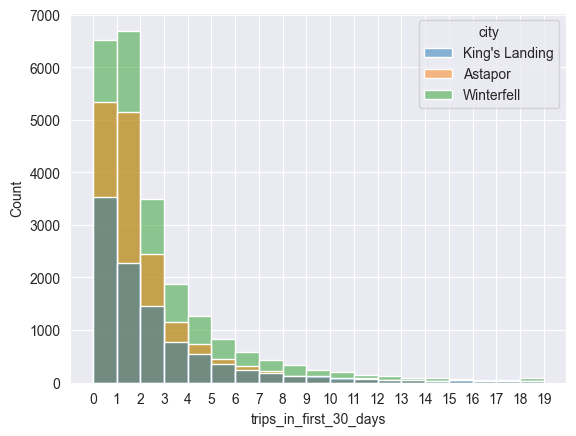

In [128]:
sns.histplot(data=data, x='trips_in_first_30_days', hue='city', bins=range(0, 20))
plt.xticks(range(0, 20))  # Задання значень для міток осі x
plt.show()

In [108]:
# Проведення тесту Крускала-Уолліса
kruskal_statistic, kruskal_p_value = kruskal(*city_groups)
print("H-statistic:", kruskal_statistic)
print("p-value:", kruskal_p_value)

H-statistic: 221.32105325317454
p-value: 8.724567791938856e-49


In [123]:
data.groupby(by='city', as_index=False).agg(
    mean=('trips_in_first_30_days','mean'),
    count=('trips_in_first_30_days','count')
)

,city,mean,count
0,Astapor,1.948651,16534
1,King's Landing,2.463672,10130
2,Winterfell,2.431179,23336


*p-value < 0.05 різниця є статистично значуща*

In [106]:
# Чи може відтік бути пов’язаний з активністю в перші 30 днів після реєстрації? (churn, trips_in_first_30_days)
# Розділення даних за відтоком
churn_groups = [data[data['churn'] == churn]['trips_in_first_30_days'] for churn in data['churn'].unique()]

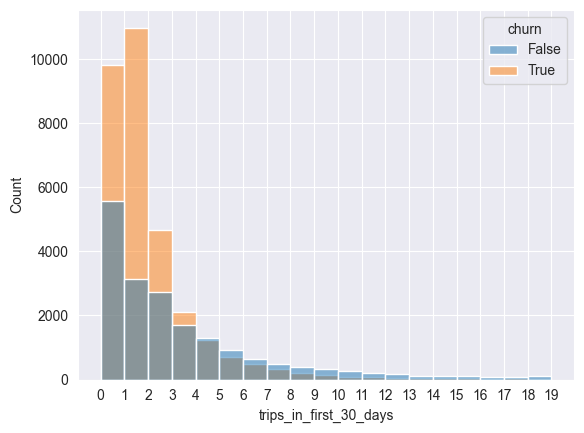

In [129]:
sns.histplot(data=data, x='trips_in_first_30_days', hue='churn', bins=range(0, 20))
plt.xticks(range(0, 20))  # Задання значень для міток осі x
plt.show()

In [110]:
# Проведення тесту Крускала-Уолліса
kruskal_statistic, kruskal_p_value = kruskal(*churn_groups)
print("Kruskal-Wallis test for comparing means (trips_in_first_30_days) between churn and non-churn groups:")
print("H-statistic:", kruskal_statistic)
print("p-value:", kruskal_p_value)

Kruskal-Wallis test for comparing means (trips_in_first_30_days) between churn and non-churn groups:
H-statistic: 1484.2728573059323
p-value: 0.0


In [124]:
data.groupby(by='churn', as_index=False).agg(
    mean=('trips_in_first_30_days','mean'),
    count=('trips_in_first_30_days','count')
)

,churn,mean,count
0,False,3.306318,18804
1,True,1.658482,31196


*Відтік може бути пов'язаний з активністю*

In [83]:
X = data[['trips_in_first_30_days', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_dist', 'surge_pct', 'weekday_pct', 'luxury_car_user', 'city']]
y = data['churn']

X['avg_rating_by_driver'].fillna(X['avg_rating_by_driver'].mean(), inplace=True)
X['avg_rating_of_driver'].fillna(X['avg_rating_of_driver'].mean(), inplace=True)
X['avg_dist'].fillna(X['avg_dist'].mean(), inplace=True)
X['city'].fillna(X['city'].mode()[0], inplace=True)

C:\Users\Dmytro\AppData\Local\Temp\ipykernel_6404\4040138076.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['avg_rating_by_driver'].fillna(X['avg_rating_by_driver'].mean(), inplace=True)
C:\Users\Dmytro\AppData\Local\Temp\ipykernel_6404\4040138076.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['avg_rating_of_driver'].fillna(X['avg_rating_of_driver'].mean(), inplace=True)
C:\Users\Dmytro\AppData\Local\Temp\ipykernel_6404\4040138076.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

In [84]:
# Закодування категоріальних змінних
X = pd.get_dummies(X)

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

In [131]:
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': rf_classifier.feature_importances_}).sort_values(by='importance', ascending=False)
print(feature_importances)

                  feature  importance
3                avg_dist    0.336926
5             weekday_pct    0.151222
1    avg_rating_by_driver    0.122509
4               surge_pct    0.105863
2    avg_rating_of_driver    0.086506
0  trips_in_first_30_days    0.086178
8     city_King's Landing    0.051791
6         luxury_car_user    0.033416
7            city_Astapor    0.014030
9         city_Winterfell    0.011559
